In [14]:
# Import dependencies
import torch
from datasets import load_dataset
import torch.nn as nn
from transformers import AutoModel, AutoTokenizer
from torch.utils.data import DataLoader, Dataset, Subset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
import time
from tqdm.auto import tqdm
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import os

In [15]:
# Specify dataset and model
DATASET_PATH = "scikit-fingerprints/MoleculeNet_Lipophilicity"
MODEL_NAME = "ibm/MoLFormer-XL-both-10pct"
EXTERNAL_DATASET_PATH = "External-Dataset_for_Task2.csv"
PRETRAINED_MODEL_PATH = "initial_regressor_model.pt"  # Path to your pre-trained model

In [16]:
class SMILESDataset(Dataset):
    def __init__(self, dataset):
        self.smiles = dataset['SMILES']  # Extract SMILES strings
        self.label = torch.tensor(dataset['label'], dtype=torch.float32)  # Convert labels to tensor

    def __len__(self):
        return len(self.smiles)

    def __getitem__(self, index):
        smiles = self.smiles[index]
        label = self.label[index]
        return {'smiles': smiles, 'label': label}

# Standard Regressor model definition
class MoLFormerWithRegressionHead(nn.Module):
    def __init__(self, model, input_dim, output_dim=1):
        super(MoLFormerWithRegressionHead, self).__init__()
        self.model = model
        self.linear_output = torch.nn.Linear(input_dim, output_dim, bias=True)
        # Add a dropout layer for uncertainty estimation
        self.dropout = nn.Dropout(p=0.1)

    def forward(self, input_ids, attention_mask=None):
        outputs = self.model(input_ids, attention_mask)
        if hasattr(outputs, 'last_hidden_state'):
            last_hidden_state = outputs.last_hidden_state
        elif hasattr(outputs, 'logits'):  # Some models (masked models) have 'logits' instead
            last_hidden_state = outputs.logits

        cls_output = last_hidden_state[:, 0, :]  # Take the first token
        cls_output = self.dropout(cls_output)  # Apply dropout for uncertainty
        output = self.linear_output(cls_output)
        return output

In [ ]:
# Function to select uncertain samples
def select_uncertain_samples(model, regressor, dataloader, tokenizer, device, selection_size):
    """Select samples where the model has the highest uncertainty in its predictions

    Args:
        model: The base model to extract embeddings
        regressor: The regression model for predictions
        dataloader: DataLoader containing the samples
        tokenizer: Tokenizer for the model
        device: Device to run the model on
        selection_size: Number of samples to select

    Returns:
        numpy array of selected indices
    """
    model.eval()
    regressor.eval()

    # Track uncertainties and indices
    all_uncertainties = []
    all_indices = []

    # We'll use Monte Carlo Dropout to estimate uncertainty
    # Enable dropout at inference time
    def enable_dropout(model):
        for module in model.modules():
            if isinstance(module, nn.Dropout):
                module.train()

    enable_dropout(regressor)

    # Number of forward passes for each sample
    n_forward_passes = 10

    with torch.no_grad():
        for i, batch in enumerate(tqdm(dataloader, desc="Estimating uncertainties")):
            smiles = batch['smiles']

            # Calculate starting index for this batch
            start_idx = i * dataloader.batch_size
            # Get actual indices for this batch
            indices = list(range(start_idx, start_idx + len(smiles)))
            all_indices.extend(indices)

            inputs = tokenizer(list(smiles), truncation=True, padding="max_length", max_length=512, return_tensors="pt")
            input_ids = inputs["input_ids"].to(device)
            attention_mask = inputs["attention_mask"].to(device)

            # Perform multiple forward passes
            batch_predictions = []
            for _ in range(n_forward_passes):
                outputs = regressor(input_ids, attention_mask).squeeze()
                batch_predictions.append(outputs.cpu().numpy())

            # Stack predictions from multiple passes
            batch_predictions = np.stack(batch_predictions)

            # Calculate standard deviation for each sample (uncertainty)
            batch_uncertainties = np.std(batch_predictions, axis=0)
            all_uncertainties.extend(batch_uncertainties)

    # Convert to numpy arrays
    all_uncertainties = np.array(all_uncertainties)
    all_indices = np.array(all_indices)

    # Select top samples with highest uncertainty
    top_uncertain_indices = all_indices[np.argsort(-all_uncertainties)[:selection_size]]

    print(f"Selected {len(top_uncertain_indices)} most uncertain samples")
    print(f"Uncertainty range: {np.min(all_uncertainties[np.argsort(-all_uncertainties)[:selection_size]]):.4f} - {np.max(all_uncertainties):.4f}")

    return top_uncertain_indices

In [18]:
def train_regular_model(model, regressor, dataloader, device, tokenizer, epochs=5):
    """Train the regular regressor model"""
    model.eval()  # Freeze embeddings
    regressor.train()

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(regressor.parameters(), lr=0.001)

    for epoch in range(epochs):
        total_loss = 0.0
        for batch in tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}"):
            smiles = batch['smiles']
            targets = batch['label'].to(device)

            inputs = tokenizer(list(smiles), truncation=True, padding="max_length", max_length=512, return_tensors="pt")
            input_ids = inputs["input_ids"].to(device)
            attention_mask = inputs["attention_mask"].to(device)

            optimizer.zero_grad()
            outputs = regressor(input_ids, attention_mask)
            loss = criterion(outputs.squeeze(), targets)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss/len(dataloader)
        print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")

    return regressor

In [19]:
def evaluate_regular_model(model, regressor, dataloader, tokenizer, device):
    """Evaluate the regular model's performance"""
    model.eval()
    regressor.eval()

    all_preds = []
    all_targets = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            smiles = batch['smiles']
            targets = batch['label'].to(device)

            inputs = tokenizer(list(smiles), truncation=True, padding="max_length", max_length=512, return_tensors="pt")
            input_ids = inputs["input_ids"].to(device)
            attention_mask = inputs["attention_mask"].to(device)

            outputs = regressor(input_ids, attention_mask).squeeze()

            all_preds.extend(outputs.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    # Calculate metrics
    mse = mean_squared_error(all_targets, all_preds)
    rmse = np.sqrt(mse)
    r2 = r2_score(all_targets, all_preds)

    return rmse, r2

BitFIt Implemnentation


In [20]:
class BitFitLinear(nn.Module):
    def __init__(self, linear_layer: nn.Linear) -> None:
        super().__init__()
        self.weight = linear_layer.weight.detach()  # Detach to prevent gradient flow
        self.bias = nn.Parameter(linear_layer.bias.clone() if linear_layer.bias is not None else torch.zeros(linear_layer.out_features, device=linear_layer.weight.device))
        self.in_features = linear_layer.in_features
        self.out_features = linear_layer.out_features

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return torch.nn.functional.linear(x, self.weight, self.bias)

def apply_bitfit_to_model(model):
    """
    Apply BitFit (bias-only fine-tuning) to a MoLFormer model

    Args:
        model: The MoLFormerWithRegressionHead model

    Returns:
        model with BitFit applied
    """
    base_model = model.model

    # Check if the model has the expected structure
    if hasattr(base_model, 'encoder') and hasattr(base_model.encoder, 'layer'):
        for transformer_block in base_model.encoder.layer:
            # Apply BitFit to intermediate dense layer
            if hasattr(transformer_block, 'intermediate') and hasattr(transformer_block.intermediate, 'dense'):
                if not isinstance(transformer_block.intermediate.dense, BitFitLinear):
                    # Keep a copy of the original linear layer weights before applying BitFit
                    original_weight = transformer_block.intermediate.dense.weight.data
                    transformer_block.intermediate.dense = BitFitLinear(transformer_block.intermediate.dense)
                    # Assign the original weights back after applying BitFit
                    transformer_block.intermediate.dense.weight.data = original_weight

            # Apply BitFit to attention layers
            if hasattr(transformer_block, 'attention') and hasattr(transformer_block.attention, 'self'):
                attention_layer = transformer_block.attention.self
                # Query
                if hasattr(attention_layer, 'query') and not isinstance(attention_layer.query, BitFitLinear):
                    original_weight = attention_layer.query.weight.data
                    attention_layer.query = BitFitLinear(attention_layer.query)
                    attention_layer.query.weight.data = original_weight
                # Key
                if hasattr(attention_layer, 'key') and not isinstance(attention_layer.key, BitFitLinear):
                    original_weight = attention_layer.key.weight.data
                    attention_layer.key = BitFitLinear(attention_layer.key)
                    attention_layer.key.weight.data = original_weight
                # Value
                if hasattr(attention_layer, 'value') and not isinstance(attention_layer.value, BitFitLinear):
                    original_weight = attention_layer.value.weight.data
                    attention_layer.value = BitFitLinear(attention_layer.value)
                    attention_layer.value.weight.data = original_weight

            # Apply BitFit to output dense layer
            if hasattr(transformer_block, 'output') and hasattr(transformer_block.output, 'dense'):
                if not isinstance(transformer_block.output.dense, BitFitLinear):
                    original_weight = transformer_block.output.dense.weight.data
                    transformer_block.output.dense = BitFitLinear(transformer_block.output.dense)
                    transformer_block.output.dense.weight.data = original_weight

    return model

def train_bitfit_model(model, regressor, dataloader, device, tokenizer, epochs=5):
    """Train the model using BitFit (bias-only fine-tuning) for efficiency"""
    model.eval()  # Freeze base model

    # Apply BitFit to the regressor
    bitfit_regressor = apply_bitfit_to_model(regressor)
    bitfit_regressor.train()

    # Only train bias parameters
    trainable_params = []
    for name, param in bitfit_regressor.named_parameters():
        if name.endswith('.bias'):
            param.requires_grad = True
            trainable_params.append(param)
        else:
            param.requires_grad = False

    print(f"Training {len(trainable_params)} BitFit parameters")

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(trainable_params, lr=0.001)

    for epoch in range(epochs):
        total_loss = 0.0
        for batch in tqdm(dataloader, desc=f"BitFit Epoch {epoch+1}/{epochs}"):
            smiles = batch['smiles']
            targets = batch['label'].to(device)

            inputs = tokenizer(list(smiles), truncation=True, padding="max_length", max_length=512, return_tensors="pt")
            input_ids = inputs["input_ids"].to(device)
            attention_mask = inputs["attention_mask"].to(device)

            optimizer.zero_grad()
            outputs = bitfit_regressor(input_ids, attention_mask)
            loss = criterion(outputs.squeeze(), targets)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss/len(dataloader)
        print(f"BitFit Epoch {epoch+1}, Loss: {avg_loss:.4f}")

    return bitfit_regressor

LORA IMPLEMENTAION


In [21]:
# Import additional dependencies if not already imported
import math
from collections import OrderedDict

# LoRA implementation
class LoRALinear(nn.Module):
    def __init__(
        self,
        linear_layer: nn.Linear,
        rank: int,
        alpha: float = 32,
    ) -> None:
        super().__init__()
        device = linear_layer.weight.device
        self.model = nn.Sequential(
            OrderedDict(
                [
                    ("lora_A", nn.Linear(linear_layer.in_features, rank, bias=False).to(device)),
                    ("lora_B", nn.Linear(rank, linear_layer.out_features, bias=False).to(device)),
                ],
            ),
        )
        self.linear_layer = linear_layer
        self.scale = alpha / rank
        self.reset_parameters()

    @property
    def weight(self):
        return self.linear_layer.weight

    # Add property for bias if needed
    @property
    def bias(self):
        return self.linear_layer.bias

    def reset_parameters(self) -> None:
        # Note: the original paper mentions that normal distribution was
        # used for initialization. However, the official LoRA implementation
        # uses "Kaiming/He Initialization".
        nn.init.kaiming_uniform_(self.model.lora_A.weight, a=math.sqrt(5))
        # Initialize B matrix to zeros so that BA = 0 in the beginning of training
        nn.init.zeros_(self.model.lora_B.weight)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear_layer(x) + self.model(x) * self.scale

# Function to apply LoRA to a model
def apply_lora_to_model(model, rank=16, alpha=32):
    """
    Apply LoRA adapters to a MoLFormer model

    Args:
        model: The MoLFormerWithRegressionHead model
        rank: Rank for LoRA adapters
        alpha: Scaling factor for LoRA

    Returns:
        model with LoRA adapters applied
    """
    base_model = model.model

    # Check if the model has the expected structure
    if hasattr(base_model, 'encoder') and hasattr(base_model.encoder, 'layer'):
        for transformer_block in base_model.encoder.layer:
            # Apply LoRA to intermediate dense layer
            if hasattr(transformer_block, 'intermediate') and hasattr(transformer_block.intermediate, 'dense'):
                if not isinstance(transformer_block.intermediate.dense, LoRALinear):
                    transformer_block.intermediate.dense = LoRALinear(transformer_block.intermediate.dense, rank, alpha)

            # Apply LoRA to attention layers
            if hasattr(transformer_block, 'attention') and hasattr(transformer_block.attention, 'self'):
                attention_layer = transformer_block.attention.self
                if hasattr(attention_layer, 'query') and not isinstance(attention_layer.query, LoRALinear):
                    attention_layer.query = LoRALinear(attention_layer.query, rank, alpha)
                if hasattr(attention_layer, 'key') and not isinstance(attention_layer.key, LoRALinear):
                    attention_layer.key = LoRALinear(attention_layer.key, rank, alpha)
                if hasattr(attention_layer, 'value') and not isinstance(attention_layer.value, LoRALinear):
                    attention_layer.value = LoRALinear(attention_layer.value, rank, alpha)

            # Apply LoRA to output dense layer
            if hasattr(transformer_block, 'output') and hasattr(transformer_block.output, 'dense'):
                if not isinstance(transformer_block.output.dense, LoRALinear):
                    transformer_block.output.dense = LoRALinear(transformer_block.output.dense, rank, alpha)

    return model

# Function to train with LoRA
def train_lora_model(model, regressor, dataloader, device, tokenizer, epochs=5, rank=16, alpha=32):
    """Train the model using LoRA adapters for efficiency"""
    model.eval()  # Freeze base model

    # Apply LoRA to the regressor
    lora_regressor = apply_lora_to_model(regressor, rank=rank, alpha=alpha)
    lora_regressor.train()

    # Only train LoRA parameters
    trainable_params = []
    for name, param in lora_regressor.named_parameters():
        if 'lora_A' in name or 'lora_B' in name:
            param.requires_grad = True
            trainable_params.append(param)
        else:
            param.requires_grad = False

    print(f"Training {len(trainable_params)} LoRA parameters")

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(trainable_params, lr=0.001)

    for epoch in range(epochs):
        total_loss = 0.0
        for batch in tqdm(dataloader, desc=f"LoRA Epoch {epoch+1}/{epochs}"):
            smiles = batch['smiles']
            targets = batch['label'].to(device)

            inputs = tokenizer(list(smiles), truncation=True, padding="max_length", max_length=512, return_tensors="pt")
            input_ids = inputs["input_ids"].to(device)
            attention_mask = inputs["attention_mask"].to(device)

            optimizer.zero_grad()
            outputs = lora_regressor(input_ids, attention_mask)
            loss = criterion(outputs.squeeze(), targets)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss/len(dataloader)
        print(f"LoRA Epoch {epoch+1}, Loss: {avg_loss:.4f}")

    return lora_regressor

IA3 Implementation

In [22]:
class IA3Linear(nn.Module):
    def __init__(self, linear_layer) -> None:
        super().__init__()
        self.linear_layer = linear_layer

        # Get out_features safely, regardless of layer type
        if hasattr(linear_layer, 'out_features'):
            out_features = linear_layer.out_features
        elif hasattr(linear_layer, 'lora_layer') and hasattr(linear_layer.lora_layer, 'out_features'):
            # For LoRA-wrapped layers
            out_features = linear_layer.lora_layer.out_features
        else:
            # Try to infer from weight shape for other custom layers
            if hasattr(linear_layer, 'weight'):
                out_features = linear_layer.weight.shape[0]
            else:
                raise ValueError(f"Cannot determine output features for layer type: {type(linear_layer)}")

        # Create the scaling vector (initialized to ones)
        device = next(linear_layer.parameters()).device
        self.scaling_vector = nn.Parameter(torch.ones(out_features, device=device))

        # Freeze the original linear layer parameters
        for param in self.linear_layer.parameters():
            param.requires_grad = False

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        output = self.linear_layer(x)

        # Apply element-wise scaling to the output
        # Reshape for proper broadcasting based on input dimensions
        if len(output.shape) == 3:  # [batch_size, seq_len, hidden_dim]
            scaling = self.scaling_vector.unsqueeze(0).unsqueeze(0)
        elif len(output.shape) == 2:  # [batch_size, hidden_dim]
            scaling = self.scaling_vector.unsqueeze(0)
        else:
            raise ValueError(f"Unsupported output shape: {output.shape}")

        return output * scaling

def apply_ia3_to_model(model):
    """
    Apply iA3 (Implicit Adapters) to a MoLFormer model,
    compatible with models that may already have LoRA applied

    Args:
        model: The MoLFormerWithRegressionHead model

    Returns:
        model with iA3 adapters applied
    """
    base_model = model.model

    # Check if the model has the expected structure
    if hasattr(base_model, 'encoder') and hasattr(base_model.encoder, 'layer'):
        for transformer_block in base_model.encoder.layer:
            # iA3 is specifically applied to query and value projections in attention
            if hasattr(transformer_block, 'attention') and hasattr(transformer_block.attention, 'self'):
                attention_layer = transformer_block.attention.self

                # Apply iA3 to query projection
                if hasattr(attention_layer, 'query') and not isinstance(attention_layer.query, IA3Linear):
                    attention_layer.query = IA3Linear(attention_layer.query)

                # Apply iA3 to value projection
                if hasattr(attention_layer, 'value') and not isinstance(attention_layer.value, IA3Linear):
                    attention_layer.value = IA3Linear(attention_layer.value)

            # Also apply iA3 to intermediate (FFN) layer as per the paper
            if hasattr(transformer_block, 'intermediate') and hasattr(transformer_block.intermediate, 'dense'):
                if not isinstance(transformer_block.intermediate.dense, IA3Linear):
                    transformer_block.intermediate.dense = IA3Linear(transformer_block.intermediate.dense)

    return model

def train_ia3_model(model, regressor, dataloader, device, tokenizer, epochs=5):
    """Train the model using iA3 (Implicit Adapters) for efficiency"""
    model.eval()  # Freeze base model

    # Apply iA3 to the regressor
    ia3_regressor = apply_ia3_to_model(regressor)
    ia3_regressor.train()

    # Only train scaling vectors
    trainable_params = []
    for name, param in ia3_regressor.named_parameters():
        if 'scaling_vector' in name:
            param.requires_grad = True
            trainable_params.append(param)
        else:
            param.requires_grad = False

    print(f"Training {len(trainable_params)} iA3 parameters")

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(trainable_params, lr=0.0001)

    for epoch in range(epochs):
        total_loss = 0.0
        for batch in tqdm(dataloader, desc=f"iA3 Epoch {epoch+1}/{epochs}"):
            smiles = batch['smiles']
            targets = batch['label'].to(device)

            inputs = tokenizer(list(smiles), truncation=True, padding="max_length", max_length=512, return_tensors="pt")
            input_ids = inputs["input_ids"].to(device)
            attention_mask = inputs["attention_mask"].to(device)

            optimizer.zero_grad()
            outputs = ia3_regressor(input_ids, attention_mask)
            loss = criterion(outputs.squeeze(), targets)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss/len(dataloader)
        print(f"iA3 Epoch {epoch+1}, Loss: {avg_loss:.4f}")

    return ia3_regressor

In [28]:
def initialize_and_run():
    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Step 1: Load datasets
    print("Loading datasets...")
    lipophilicity_dataset = load_dataset(DATASET_PATH)
    external_dataset = pd.read_csv(EXTERNAL_DATASET_PATH)

    # Split the data
    train_test_split = lipophilicity_dataset["train"].train_test_split(test_size=0.25, seed=42)
    train_dataset = train_test_split["train"]
    test_dataset = train_test_split["test"]

    # Create dataset objects
    train_smiles_dataset = SMILESDataset(train_dataset)
    test_smiles_dataset = SMILESDataset(test_dataset)
    external_smiles_dataset = SMILESDataset(external_dataset)

    # Create dataloaders
    BATCH_SIZE = 16
    train_dataloader = DataLoader(train_smiles_dataset, batch_size=BATCH_SIZE, shuffle=True)
    test_dataloader = DataLoader(test_smiles_dataset, batch_size=BATCH_SIZE, shuffle=False)
    external_dataloader = DataLoader(external_smiles_dataset, batch_size=BATCH_SIZE, shuffle=False)

    # Step 2: Load models - Create separate base models for each method
    print("Loading models...")
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, trust_remote_code=True)

    # Base model for initial training and evaluation
    base_model = AutoModel.from_pretrained(MODEL_NAME, deterministic_eval=True, trust_remote_code=True).to(device)

    # Separate base model instances for each PEFT method
    base_model_bitfit = AutoModel.from_pretrained(MODEL_NAME, deterministic_eval=True, trust_remote_code=True).to(device)
    base_model_lora = AutoModel.from_pretrained(MODEL_NAME, deterministic_eval=True, trust_remote_code=True).to(device)
    base_model_ia3 = AutoModel.from_pretrained(MODEL_NAME, deterministic_eval=True, trust_remote_code=True).to(device)

    # Step 3: Load pre-trained regressor model
    print("Loading pre-trained regressor model...")
    regressor = MoLFormerWithRegressionHead(base_model, 768).to(device)

    # Check if the pre-trained model exists
    if os.path.exists(PRETRAINED_MODEL_PATH):
        checkpoint = torch.load(PRETRAINED_MODEL_PATH)
        regressor.load_state_dict(checkpoint['model_state_dict'])
        initial_rmse = checkpoint.get('rmse', 0)
        initial_r2 = checkpoint.get('r2', 0)
        print(f"Pre-trained model loaded - RMSE: {initial_rmse:.4f}, R²: {initial_r2:.4f}")
    else:
        print("Pre-trained model not found. Please train the initial model first.")
        return

    # Step 4: Select uncertain samples
    print(f"Selecting 100 most uncertain samples from external dataset...")

    # Create a path to store selected indices
    SELECTED_INDICES_PATH = 'selected_indices.pt'

    # Check if we already have the selected indices
    if os.path.exists(SELECTED_INDICES_PATH):
        selected_indices = torch.load(SELECTED_INDICES_PATH)
        print(f"Loaded {len(selected_indices)} previously selected indices")
    else:
        selected_indices = select_uncertain_samples(
            base_model,
            regressor,
            external_dataloader,
            tokenizer,
            device,
            selection_size=100  # Selecting exactly 100 samples
        )
        # Save the selected indices for future use
        torch.save(selected_indices, SELECTED_INDICES_PATH)

    # Create a subset of external dataset with selected samples
    selected_external_dataset = Subset(external_smiles_dataset, selected_indices.tolist())

    # Log data selection findings
    print("\n--- Data Selection Findings ---")
    selection_percentage = len(selected_indices) / len(external_smiles_dataset)
    print(f"Data selection strategy: Uncertainty-based selection using Monte Carlo Dropout")
    print(f"External dataset size: {len(external_smiles_dataset)}")
    print(f"Selected data size: {len(selected_indices)} ({selection_percentage*100:.1f}% of external dataset)")

    # Create a combined dataset from original training data and selected uncertain samples
    combined_dataset = torch.utils.data.ConcatDataset([train_smiles_dataset, selected_external_dataset])
    combined_dataloader = DataLoader(combined_dataset, batch_size=BATCH_SIZE, shuffle=True)
    print(f"Combined dataset size: {len(combined_dataset)} samples")

    # Step 5: Fine-tune regular model on selected data if not already done
    UNCERTAINTY_MODEL_PATH = 'uncertainty_finetuned_model.pt'

    if os.path.exists(UNCERTAINTY_MODEL_PATH):
        print("\nLoading existing uncertainty-based fine-tuned model...")
        ft_checkpoint = torch.load(UNCERTAINTY_MODEL_PATH)
        ft_regressor = MoLFormerWithRegressionHead(base_model, 768).to(device)
        ft_regressor.load_state_dict(ft_checkpoint['model_state_dict'])
        ft_rmse = ft_checkpoint.get('rmse', 0)
        ft_r2 = ft_checkpoint.get('r2', 0)
        print(f"Fine-tuned model loaded - RMSE: {ft_rmse:.4f}, R²: {ft_r2:.4f}")
    else:
        print("\nFine-tuning model on combined dataset (original training + selected uncertain samples)...")
        ft_regressor = MoLFormerWithRegressionHead(base_model, 768).to(device)
        # First copy the weights from initial regressor
        ft_regressor.load_state_dict(regressor.state_dict())

        # Then fine-tune on the combined dataset
        ft_regressor = train_regular_model(base_model, ft_regressor, combined_dataloader, device, tokenizer, epochs=5)

        # Evaluate fine-tuned model on selected data
        ft_rmse, ft_r2 = evaluate_regular_model(base_model, ft_regressor, test_dataloader, tokenizer, device)
        print(f"Fine-tuned model - RMSE: {ft_rmse:.4f}, R²: {ft_r2:.4f}")
        print(f"Improvement - RMSE: {initial_rmse - ft_rmse:.4f}, R²: {ft_r2 - initial_r2:.4f}")
        print("Saving fine-tuned regressor model...")

        torch.save({
            'model_state_dict': ft_regressor.state_dict(),
            'rmse': ft_rmse,
            'r2': ft_r2,
        }, UNCERTAINTY_MODEL_PATH)

    # Step 6: Fine-tune model with BitFit if not already done
    BITFIT_MODEL_PATH = 'bitfit_finetuned_model.pt'

    if os.path.exists(BITFIT_MODEL_PATH):
        print("\nLoading existing BitFit fine-tuned model...")
        bitfit_checkpoint = torch.load(BITFIT_MODEL_PATH)
        # Use dedicated BitFit base model instance
        bitfit_regressor = MoLFormerWithRegressionHead(base_model_bitfit, 768).to(device)

        # Apply BitFit modifications BEFORE loading state dict
        bitfit_regressor = apply_bitfit_to_model(bitfit_regressor)

        # Now load the state dictionary
        bitfit_regressor.load_state_dict(bitfit_checkpoint['model_state_dict'])

        bitfit_rmse = bitfit_checkpoint.get('rmse', 0)
        bitfit_r2 = bitfit_checkpoint.get('r2', 0)
        print(f"BitFit model loaded - RMSE: {bitfit_rmse:.4f}, R²: {bitfit_r2:.4f}")
    else:
        print("\nFine-tuning model with BitFit on combined dataset...")
        # Apply BitFit and train with dedicated base model
        bitfit_regressor = MoLFormerWithRegressionHead(base_model_bitfit, 768).to(device)
        bitfit_regressor.load_state_dict(regressor.state_dict())
        bitfit_regressor = train_bitfit_model(
            base_model_bitfit,
            bitfit_regressor,
            combined_dataloader,
            device,
            tokenizer,
            epochs=5
        )

        # Evaluate fine-tuned model with BitFit
        bitfit_rmse, bitfit_r2 = evaluate_regular_model(base_model_bitfit, bitfit_regressor, test_dataloader, tokenizer, device)
        print(f"\nBitFit fine-tuned model - RMSE: {bitfit_rmse:.4f}, R²: {bitfit_r2:.4f}")
        print(f"Improvement - RMSE: {initial_rmse - bitfit_rmse:.4f}, R²: {bitfit_r2 - initial_r2:.4f}")

        # Save BitFit model
        torch.save({
            'model_state_dict': bitfit_regressor.state_dict(),
            'rmse': bitfit_rmse,
            'r2': bitfit_r2
        }, BITFIT_MODEL_PATH)

    # Step 7: Fine-tune model with LoRA if not already done
    LORA_MODEL_PATH = 'lora_finetuned_model.pt'
    LORA_RANK = 16
    LORA_ALPHA = 32

    if os.path.exists(LORA_MODEL_PATH):
        print("\nLoading existing LoRA fine-tuned model...")
        lora_checkpoint = torch.load(LORA_MODEL_PATH)
        # Use dedicated LoRA base model instance
        lora_regressor = MoLFormerWithRegressionHead(base_model_lora, 768).to(device)

        # Get LoRA hyperparameters from checkpoint
        LORA_RANK = lora_checkpoint.get('lora_rank', LORA_RANK)
        LORA_ALPHA = lora_checkpoint.get('lora_alpha', LORA_ALPHA)
        lora_regressor = apply_lora_to_model(lora_regressor, rank=LORA_RANK, alpha=LORA_ALPHA)
        lora_regressor.load_state_dict(lora_checkpoint['model_state_dict'])
        lora_rmse = lora_checkpoint.get('rmse', 0)
        lora_r2 = lora_checkpoint.get('r2', 0)
        print(f"LoRA model loaded - RMSE: {lora_rmse:.4f}, R²: {lora_r2:.4f}")

    else:
        print("\nFine-tuning model with LoRA on combined dataset...")

        # Fine-tune with LoRA using dedicated base model
        lora_regressor = MoLFormerWithRegressionHead(base_model_lora, 768).to(device)
        lora_regressor.load_state_dict(regressor.state_dict())
        lora_regressor = train_lora_model(
            base_model_lora,
            lora_regressor,
            combined_dataloader,
            device,
            tokenizer,
            epochs=5,
            rank=LORA_RANK,
            alpha=LORA_ALPHA
        )

        # Evaluate fine-tuned model with LoRA
        lora_rmse, lora_r2 = evaluate_regular_model(base_model_lora, lora_regressor, test_dataloader, tokenizer, device)
        print(f"\nLoRA fine-tuned model - RMSE: {lora_rmse:.4f}, R²: {lora_r2:.4f}")
        print(f"Improvement - RMSE: {initial_rmse - lora_rmse:.4f}, R²: {lora_r2 - initial_r2:.4f}")

        # Save model
        torch.save({
            'model_state_dict': lora_regressor.state_dict(),
            'rmse': lora_rmse,
            'r2': lora_r2,
            'lora_rank': LORA_RANK,
            'lora_alpha': LORA_ALPHA
        }, LORA_MODEL_PATH)

    # Step 8: Fine-tune model with iA3 if not already done
    IA3_MODEL_PATH = 'ia3_finetuned_model.pt'

    if os.path.exists(IA3_MODEL_PATH):
        print("\nLoading existing iA3 fine-tuned model...")
        ia3_checkpoint = torch.load(IA3_MODEL_PATH)
        # Use dedicated iA3 base model instance
        ia3_regressor = MoLFormerWithRegressionHead(base_model_ia3, 768).to(device)

        # Apply iA3 adaptations BEFORE loading state dict
        ia3_regressor = apply_ia3_to_model(ia3_regressor)

        # Now load the state dictionary
        ia3_regressor.load_state_dict(ia3_checkpoint['model_state_dict'])

        ia3_rmse = ia3_checkpoint.get('rmse', 0)
        ia3_r2 = ia3_checkpoint.get('r2', 0)
        print(f"iA3 model loaded - RMSE: {ia3_rmse:.4f}, R²: {ia3_r2:.4f}")
    else:
        print("\nFine-tuning model with iA3 on combined dataset...")
        # Apply iA3 and train using dedicated base model
        ia3_regressor = MoLFormerWithRegressionHead(base_model_ia3, 768).to(device)
        ia3_regressor.load_state_dict(regressor.state_dict())
        ia3_regressor = train_ia3_model(
            base_model_ia3,
            ia3_regressor,
            combined_dataloader,
            device,
            tokenizer,
            epochs=5
        )

        # Evaluate fine-tuned model with iA3
        ia3_rmse, ia3_r2 = evaluate_regular_model(base_model_ia3, ia3_regressor, test_dataloader, tokenizer, device)
        print(f"\niA3 fine-tuned model - RMSE: {ia3_rmse:.4f}, R²: {ia3_r2:.4f}")
        print(f"Improvement - RMSE: {initial_rmse - ia3_rmse:.4f}, R²: {ia3_r2 - initial_r2:.4f}")

        # Save iA3 model
        torch.save({
            'model_state_dict': ia3_regressor.state_dict(),
            'rmse': ia3_rmse,
            'r2': ia3_r2
        }, IA3_MODEL_PATH)

    # Prepare data for comparison plot
    methods = ['Fine-Tuned', 'ft_Ext_data', 'BitFit', 'LoRA', 'iA3']
    rmse_values = [initial_rmse, ft_rmse, bitfit_rmse, lora_rmse, ia3_rmse]
    r2_values = [initial_r2, ft_r2, bitfit_r2, lora_r2, ia3_r2]
    colors = ['lightblue', 'salmon', 'lightgreen', 'lightyellow', 'pink']

    # Create comparison plots
    plt.figure(figsize=(14, 6))

    # RMSE comparison (lower is better)
    plt.subplot(1, 2, 1)
    bars = plt.bar(methods, rmse_values, color=colors)
    plt.ylabel('RMSE (lower is better)')
    plt.title('RMSE Comparison')
    plt.xticks(rotation=15)  # Rotate labels for better readability

    # Add value labels on top of each bar
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.4f}', ha='center', va='bottom')

    # R² comparison (higher is better)
    plt.subplot(1, 2, 2)
    bars = plt.bar(methods, r2_values, color=colors)
    plt.ylabel('R² (higher is better)')
    plt.title('R² Comparison')
    plt.xticks(rotation=15)

    # Add value labels on top of each bar
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.4f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.savefig('peft_methods_comparison.png')

    # Print summary of improvements
    print("\n--- PEFT Methods Comparison ---")
    print(f"Pre-trained model baseline - RMSE: {initial_rmse:.4f}, R²: {initial_r2:.4f}")
    print(f"Standard FT improvement - RMSE: {initial_rmse - ft_rmse:.4f} ({(initial_rmse - ft_rmse)/initial_rmse*100:.1f}%), R²: {ft_r2 - initial_r2:.4f} ({(ft_r2 - initial_r2)/initial_r2*100:.1f}%)")
    print(f"LoRA improvement     - RMSE: {initial_rmse - lora_rmse:.4f} ({(initial_rmse - lora_rmse)/initial_rmse*100:.1f}%), R²: {lora_r2 - initial_r2:.4f} ({(lora_r2 - initial_r2)/initial_r2*100:.1f}%)")
    print(f"BitFit improvement   - RMSE: {initial_rmse - bitfit_rmse:.4f} ({(initial_rmse - bitfit_rmse)/initial_rmse*100:.1f}%), R²: {bitfit_r2 - initial_r2:.4f} ({(bitfit_r2 - initial_r2)/initial_r2*100:.1f}%)")
    print(f"iA3 improvement      - RMSE: {initial_rmse - ia3_rmse:.4f} ({(initial_rmse - ia3_rmse)/initial_rmse*100:.1f}%), R²: {ia3_r2 - initial_r2:.4f} ({(ia3_r2 - initial_r2)/initial_r2*100:.1f}%)")

    # Count trainable parameters for each method
    def count_trainable_params(model):
        return sum(p.numel() for p in model.parameters() if p.requires_grad)

    print("\n--- Trainable Parameters ---")
    print(f"Standard FT: {count_trainable_params(ft_regressor):,} parameters")
    print(f"LoRA:        {count_trainable_params(lora_regressor):,} parameters")
    print(f"BitFit:      {count_trainable_params(bitfit_regressor):,} parameters")
    print(f"iA3:         {count_trainable_params(ia3_regressor):,} parameters")

    # Return results in a dictionary
    results = {
        'strategy': 'Uncertainty-based Selection using Monte Carlo Dropout',
        'lora_rank': LORA_RANK,
        'lora_alpha': LORA_ALPHA,
        'data_used': len(selected_indices),
        'percentage': selection_percentage * 100,
        'initial_rmse': initial_rmse,
        'initial_r2': initial_r2,
        'fine_tuned_rmse': ft_rmse,
        'fine_tuned_r2': ft_r2,
        'improvement_rmse': initial_rmse - ft_rmse,
        'improvement_r2': ft_r2 - initial_r2,
        'lora_rmse': lora_rmse,
        'lora_r2': lora_r2,
        'improvement_rmse_with_lora': initial_rmse - lora_rmse,
        'improvement_r2_with_lora': lora_r2 - initial_r2,
        'bitfit_rmse': bitfit_rmse,
        'bitfit_r2': bitfit_r2,
        'improvement_rmse_with_bitfit': initial_rmse - bitfit_rmse,
        'improvement_r2_with_bitfit': bitfit_r2 - initial_r2,
        'ia3_rmse': ia3_rmse,
        'ia3_r2': ia3_r2,
        'improvement_rmse_with_ia3': initial_rmse - ia3_rmse,
        'improvement_r2_with_ia3': ia3_r2 - initial_r2
    }

    return results

In [29]:
import warnings
warnings.filterwarnings('ignore')

Using device: cuda
Loading datasets...
Loading models...
Loading pre-trained regressor model...
Pre-trained model loaded - RMSE: 0.7024, R²: 0.6419
Selecting 100 most uncertain samples from external dataset...
Loaded 100 previously selected indices

--- Data Selection Findings ---
Data selection strategy: Uncertainty-based selection using Monte Carlo Dropout
External dataset size: 300
Selected data size: 100 (33.3% of external dataset)
Combined dataset size: 3250 samples

Loading existing uncertainty-based fine-tuned model...
Fine-tuned model loaded - RMSE: 0.6615, R²: 0.6824

Fine-tuning model with BitFit on combined dataset...
Training 98 BitFit parameters


BitFit Epoch 1/5:   0%|          | 0/204 [00:00<?, ?it/s]

BitFit Epoch 1, Loss: 0.1495


BitFit Epoch 2/5:   0%|          | 0/204 [00:00<?, ?it/s]

BitFit Epoch 2, Loss: 0.1408


BitFit Epoch 3/5:   0%|          | 0/204 [00:00<?, ?it/s]

BitFit Epoch 3, Loss: 0.1335


BitFit Epoch 4/5:   0%|          | 0/204 [00:00<?, ?it/s]

BitFit Epoch 4, Loss: 0.1301


BitFit Epoch 5/5:   0%|          | 0/204 [00:00<?, ?it/s]

BitFit Epoch 5, Loss: 0.1293


Evaluating:   0%|          | 0/66 [00:00<?, ?it/s]


BitFit fine-tuned model - RMSE: 0.6077, R²: 0.7319
Improvement - RMSE: 0.0946, R²: 0.0900

Fine-tuning model with LoRA on combined dataset...
Training 120 LoRA parameters


LoRA Epoch 1/5:   0%|          | 0/204 [00:00<?, ?it/s]

LoRA Epoch 1, Loss: 0.1684


LoRA Epoch 2/5:   0%|          | 0/204 [00:00<?, ?it/s]

LoRA Epoch 2, Loss: 0.1521


LoRA Epoch 3/5:   0%|          | 0/204 [00:00<?, ?it/s]

LoRA Epoch 3, Loss: 0.1669


LoRA Epoch 4/5:   0%|          | 0/204 [00:00<?, ?it/s]

LoRA Epoch 4, Loss: 0.1568


LoRA Epoch 5/5:   0%|          | 0/204 [00:00<?, ?it/s]

LoRA Epoch 5, Loss: 0.1518


Evaluating:   0%|          | 0/66 [00:00<?, ?it/s]


LoRA fine-tuned model - RMSE: 0.6611, R²: 0.6828
Improvement - RMSE: 0.0413, R²: 0.0409

Fine-tuning model with iA3 on combined dataset...
Training 36 iA3 parameters


iA3 Epoch 1/5:   0%|          | 0/204 [00:00<?, ?it/s]

iA3 Epoch 1, Loss: 0.1855


iA3 Epoch 2/5:   0%|          | 0/204 [00:00<?, ?it/s]

iA3 Epoch 2, Loss: 0.1699


iA3 Epoch 3/5:   0%|          | 0/204 [00:00<?, ?it/s]

iA3 Epoch 3, Loss: 0.1650


iA3 Epoch 4/5:   0%|          | 0/204 [00:00<?, ?it/s]

iA3 Epoch 4, Loss: 0.1573


iA3 Epoch 5/5:   0%|          | 0/204 [00:00<?, ?it/s]

iA3 Epoch 5, Loss: 0.1591


Evaluating:   0%|          | 0/66 [00:00<?, ?it/s]


iA3 fine-tuned model - RMSE: 0.6564, R²: 0.6873
Improvement - RMSE: 0.0460, R²: 0.0453

--- PEFT Methods Comparison ---
Pre-trained model baseline - RMSE: 0.7024, R²: 0.6419
Standard FT improvement - RMSE: 0.0408 (5.8%), R²: 0.0404 (6.3%)
LoRA improvement     - RMSE: 0.0413 (5.9%), R²: 0.0409 (6.4%)
BitFit improvement   - RMSE: 0.0946 (13.5%), R²: 0.0900 (14.0%)
iA3 improvement      - RMSE: 0.0460 (6.5%), R²: 0.0453 (7.1%)

--- Trainable Parameters ---
Standard FT: 44,375,809 parameters
LoRA:        1,474,560 parameters
BitFit:      74,497 parameters
iA3:         27,648 parameters
Total execution time: 1827.14 seconds


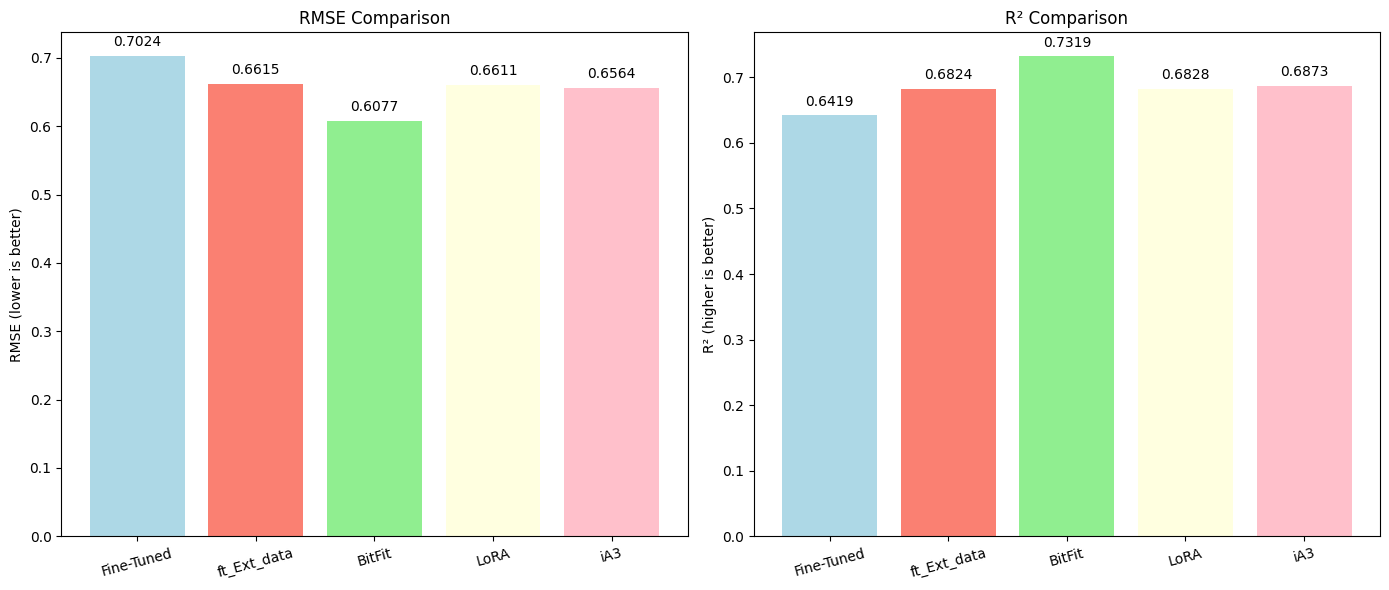

In [30]:
if __name__ == "__main__":
    start_time = time.time()
    results = initialize_and_run()
    total_time = time.time() - start_time
    print(f"Total execution time: {total_time:.2f} seconds")